In [1]:
import torch
import pickle
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline



In [2]:
feature_nn = torch.load('21101_feature_nn.pt')


In [3]:
labels = ['time', 'e+_near', 'e-_near', 'max_strength_mmr_near', 'e+_far', 'e-_far', 'max_strength_mmr_far', 'megno', 'a1', 'e1', 'i1', 'cos_Omega1', 'sin_Omega1', 'cos_pomega1', 'sin_pomega1', 'cos_theta1', 'sin_theta1', 'a2', 'e2', 'i2', 'cos_Omega2', 'sin_Omega2', 'cos_pomega2', 'sin_pomega2', 'cos_theta2', 'sin_theta2', 'a3', 'e3', 'i3', 'cos_Omega3', 'sin_Omega3', 'cos_pomega3', 'sin_pomega3', 'cos_theta3', 'sin_theta3', 'm1', 'm2', 'm3', 'nan_mmr_near', 'nan_mmr_far', 'nan_megno']

# not all of these labels are actually used. for training, these inputs are zeroed out, but still passed in as zeroes.
# ideally, the linear layer ignores them, which does happen if i do l1 regularization to it
skipped = ['nan_mmr_near', 'nan_mmr_far', 'nan_megno', 'e+_near', 'e-_near', 'max_strength_mmr_near', 'e+_far', 'e-_far', 'max_strength_mmr_far', 'megno']

In [4]:
results_path = 'hall_of_fame_f2_21101_0_1.pkl'
results = pickle.load(open(results_path, 'rb'))
results = results.equations_[0]  # equations for predicting the mean

In [5]:
# this gives the (n_features, n_inputs) matrix of the linear transformation used as f1
input_linear = feature_nn.weight.detach().numpy()
input_linear.shape

(20, 41)

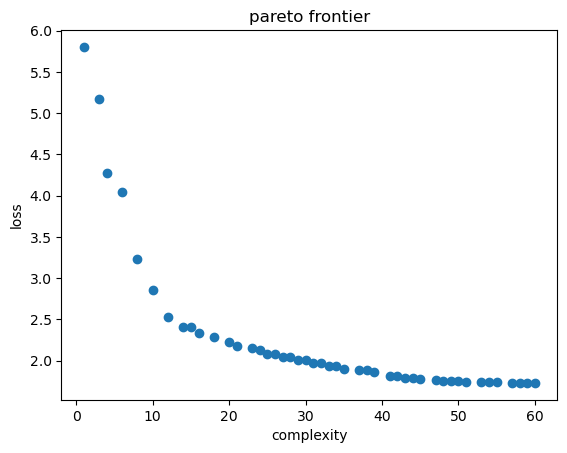

In [6]:
# plot the pareto curve for results
x = results['complexity']
y = results['loss']
# plot the pareto frontier
plt.scatter(x, y)
plt.xlabel('complexity')
plt.ylabel('loss')
plt.title('pareto frontier')
plt.show()


In [9]:
results[0:20]

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,5.803489,0.000000,6.9754324,6.97543240000000,PySRFunction(X=>6.97543240000000)
1,3,5.177424,0.057076,(7.5690565 - s16),7.5690565 - s16,PySRFunction(X=>7.5690565 - s16)
2,4,4.270199,0.192647,(4.8838587 - log(s4)),4.8838587 - log(s4),PySRFunction(X=>4.8838587 - log(s4))
3,6,4.039780,0.027735,((5.7062464 - log(s4)) - s11),-s11 - log(s4) + 5.7062464,PySRFunction(X=>-s11 - log(s4) + 5.7062464)
4,8,3.233104,0.111374,((4.6465693 - log(s4)) + (0.20312724 * m0)),0.20312724*m0 - log(s4) + 4.6465693,PySRFunction(X=>0.20312724*m0 - log(s4) + 4.64...
5,10,2.853313,0.062481,((4.1890907 - log(s4)) + (0.15476178 * (m5 + m...,0.15476178*m0 + 0.15476178*m5 - log(s4) + 4.18...,PySRFunction(X=>0.15476178*m0 + 0.15476178*m5 ...
6,12,2.530805,0.059972,((4.045565 - log(s4)) + (0.17270839 * ((m5 + m...,0.17270839*m0 + 0.17270839*m13 + 0.17270839*m5...,PySRFunction(X=>0.17270839*m0 + 0.17270839*m13...
7,14,2.409025,0.024658,((4.1638684 - log(s4)) + (0.15841591 * ((m5 - ...,0.15841591*m0 + 0.15841591*m13 - 0.15841591*m1...,PySRFunction(X=>0.15841591*m0 + 0.15841591*m13...
8,15,2.409011,0.000006,((4.1638684 - log(s4)) + (sin(0.15841591) * ((...,0.157754150509143*m0 + 0.157754150509143*m13 -...,PySRFunction(X=>0.157754150509143*m0 + 0.15775...
9,16,2.328622,0.033940,((4.1638684 - log(s4)) + (0.15841591 * (((m0 -...,0.15841591*m0 + 0.15841591*m13 - 0.15841591*m1...,PySRFunction(X=>0.15841591*m0 + 0.15841591*m13...


In [10]:
# let's interpret the complexity 8 equation as an example
# get entry where complexity = 8
results[results['complexity'] == 8]


,complexity,loss,score,equation,sympy_format,lambda_format
4,8,3.233104,0.111374,((4.6465693 - log(s4)) + (0.20312724 * m0)),0.20312724*m0 - log(s4) + 4.6465693,PySRFunction(X=>0.20312724*m0 - log(s4) + 4.64...


In [13]:
# m_i is the mean of the i'th feature, s_i is the standard deviation
# get the linear transformation that creates feature i
def linear_transformation(i):
    return input_linear[i]

In [14]:
linear_transformation(0)

array([ 2.4963992e-02, -2.6918179e-04,  1.3640006e-03, -4.3821856e-03,
       -3.8846429e-03,  6.9017392e-03,  4.4168332e-03, -7.6589030e-03,
       -3.7236292e-02, -3.6807179e-01, -1.0621831e-02,  1.5267141e-02,
        7.8285247e-04, -2.3536950e-03, -1.5936531e-02,  1.0689994e-02,
       -1.1738592e-02,  2.3591283e-01, -2.5967073e-01, -5.8360647e-02,
       -8.4318370e-03,  4.6797097e-05,  1.0838765e-02, -1.6435623e-03,
        5.5487994e-03, -2.0299401e-04,  3.7890193e+00, -3.1239390e-01,
       -6.0978349e-02,  4.8777545e-04, -2.9934703e-03, -1.6549183e-02,
       -1.5811358e-03, -6.8783103e-03, -1.0354895e-03, -4.6030140e+00,
        6.3512731e-01, -1.5065593e+00,  1.7115632e-03,  3.6310107e-03,
        8.7366598e-03], dtype=float32)

In [15]:
# let's make the linear transformation a bit easier to read
def format_num(x):
    if abs(x) > 0.1:
        return f'{x:.2f}'
    if abs(x) > 0.01:
        return f'{x:.3f}'
    elif abs(x) > 0.001:
        return f'{x:.4f}'
    else:
        return f'{x:.2e}'

format_vec = np.vectorize(format_num)

In [16]:
format_vec(linear_transformation(0))

array(['0.025', '-2.69e-04', '0.0014', '-0.0044', '-0.0039', '0.0069',
       '0.0044', '-0.0077', '-0.037', '-0.37', '-0.011', '0.015',
       '7.83e-04', '-0.0024', '-0.016', '0.011', '-0.012', '0.24',
       '-0.26', '-0.058', '-0.0084', '4.68e-05', '0.011', '-0.0016',
       '0.0055', '-2.03e-04', '3.79', '-0.31', '-0.061', '4.88e-04',
       '-0.0030', '-0.017', '-0.0016', '-0.0069', '-0.0010', '-4.60',
       '0.64', '-1.51', '0.0017', '0.0036', '0.0087'], dtype='<U9')

In [25]:
# now we can write it as a combination of the input features
# we'll sort the features by their absolute value to make it a bit easier to read
def feature_equation(i):
    transformation = linear_transformation(i)
    sorted_ixs = np.argsort(np.abs(transformation))[::-1]
    return ' +\n'.join([format_num(transformation[i]) + ' * ' + labels[i] for i in sorted_ixs if transformation[i] != 0])

In [20]:
results[results['complexity'] == 8]

,complexity,loss,score,equation,sympy_format,lambda_format
4,8,3.233104,0.111374,((4.6465693 - log(s4)) + (0.20312724 * m0)),0.20312724*m0 - log(s4) + 4.6465693,PySRFunction(X=>0.20312724*m0 - log(s4) + 4.64...


In [27]:
print(feature_equation(0))

-4.60 * m1 +
3.79 * a3 +
-1.51 * m3 +
0.64 * m2 +
-0.37 * e1 +
-0.31 * e3 +
-0.26 * e2 +
0.24 * a2 +
-0.061 * i3 +
-0.058 * i2 +
-0.037 * a1 +
0.025 * time +
-0.017 * cos_pomega3 +
-0.016 * sin_pomega1 +
0.015 * cos_Omega1 +
-0.012 * sin_theta1 +
0.011 * cos_pomega2 +
0.011 * cos_theta1 +
-0.011 * i1 +
0.0087 * nan_megno +
-0.0084 * cos_Omega2 +
-0.0077 * megno +
0.0069 * e-_far +
-0.0069 * cos_theta3 +
0.0055 * cos_theta2 +
0.0044 * max_strength_mmr_far +
-0.0044 * max_strength_mmr_near +
-0.0039 * e+_far +
0.0036 * nan_mmr_far +
-0.0030 * sin_Omega3 +
-0.0024 * cos_pomega1 +
0.0017 * nan_mmr_near +
-0.0016 * sin_pomega2 +
-0.0016 * sin_pomega3 +
0.0014 * e-_near +
-0.0010 * sin_theta3 +
7.83e-04 * sin_Omega1 +
4.88e-04 * cos_Omega3 +
-2.69e-04 * e+_near +
-2.03e-04 * sin_theta2 +
4.68e-05 * sin_Omega2


In [28]:
print(feature_equation(4))

-17.87 * a2 +
16.07 * a3 +
1.58 * a1 +
-0.24 * m3 +
-0.081 * m2 +
0.060 * m1 +
-0.015 * cos_Omega1 +
0.013 * i3 +
-0.0093 * e1 +
-0.0087 * e3 +
0.0087 * cos_pomega3 +
0.0081 * time +
-0.0071 * sin_pomega3 +
-0.0071 * cos_theta1 +
0.0058 * nan_mmr_far +
0.0056 * cos_pomega2 +
-0.0054 * i2 +
-0.0049 * e+_far +
0.0048 * cos_Omega3 +
-0.0047 * max_strength_mmr_far +
-0.0046 * sin_pomega2 +
-0.0044 * max_strength_mmr_near +
0.0041 * sin_Omega1 +
-0.0040 * megno +
-0.0037 * cos_theta3 +
0.0036 * sin_theta1 +
-0.0032 * nan_mmr_near +
-0.0031 * nan_megno +
0.0031 * sin_theta2 +
-0.0027 * sin_pomega1 +
0.0026 * cos_pomega1 +
-0.0025 * sin_Omega2 +
-0.0023 * cos_Omega2 +
-0.0021 * sin_Omega3 +
0.0021 * i1 +
0.0020 * e-_far +
0.0017 * sin_theta3 +
0.0017 * cos_theta2 +
0.0011 * e2 +
-6.83e-04 * e-_near +
8.57e-05 * e+_near
